# 빅데이터처리
## Week05_Quiz1
### 2016003709 윤가영

In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [4]:
def create_dataset(N, D=2, minval=[0, 0], maxval=[1, 1]):
    """
    D차원 벡터 N개를 생성
    """
    
    dataset = np.zeros((N, D+1))
    
    #gen IDs
    dataset[:, 0] = np.arange(1, N+1, dtype='int')
    
    #gen values
    for i in range(D):
        vec = np.random.rand(N) * (maxval[i] - minval[i]) + minval[i]
        dataset[:, i+1] = vec
        
    return dataset

#### map 함수

In [5]:
def maker(idx, vec, g, gnum):
    bid = math.ceil(idx/g)

    result = []
    for i in range(1, gnum+1):
        if(i <= bid):
            key = (i, bid)
            value = (idx, vec)
            t = (key, value)
            result.append(t)
        
        elif(i > bid):
            key = (bid, i)
            value = (idx, vec)
            t = (key, value)
            result.append(t)
    
    return result

#### filtering 함수

In [6]:
def check_distance(v1, v2, threshold=0.01):
    d1 = (v2[0]-v1[0]) ** 2
    d2 = (v2[1]-v1[1]) ** 2
    
    distance = math.sqrt(d1 + d2)
    
    if(distance <= threshold):
        return True
    
    return False

#### reduce 함수

In [7]:
def reducer(key, li, g, gnum):
    x = key[0]
    y = key[1]
    
    result = []
    
    if(x == y):
        length = len(li)
        for i in range(0, length-1):
            id_r = li[i][0]
            vec_r = li[i][1]  
            for j in range(i+1, length):
                id_s = li[j][0]
                vec_s = li[j][1]
                
                if(check_distance(vec_r, vec_s)):
                    result.append(((id_r, id_s), (vec_r, vec_s)))
                
    else:
        list_r = []
        list_s = []
        for (idx, vec) in li:
            bid = math.ceil(idx/g)
            if(bid == x):
                list_r.append((idx,vec))
            elif(bid == y):
                list_s.append((idx,vec))
        print(len(list_r))
        print(len(list_s))
        for (id_r, vec_r) in list_r:
            for (id_s, vec_s) in list_s:
                if(check_distance(vec_r, vec_s)):
                    result.append(((id_r, id_s), (vec_r, vec_s)))
    return result

#### Quiz1 해답

In [8]:
def Quiz1(dataset, group=[1,2,4,8]):
    length = dataset.shape[0]
    
    results = []
    durations = []
    for g in group:
        start = time.time()
        
        RDD = sc.parallelize(dataset).map(lambda x: list(x)).flatMap(lambda x: maker(x[0], x[1:], length/g, g)) 
        result = RDD.groupByKey().flatMap(lambda x: reducer(x[0], list(x[1]), length/g, g)).count()

        end = time.time()
        duration = end - start
        
        results.append(result)
        durations.append(duration)
        
    return results, durations

#### Quiz1 실행코드

In [9]:
X = [200, 400, 800, 1600]

In [32]:
results = []
durations = []

for i in range(4):
    print("[Dataset: {}]".format(X[i]))
    print()
    
    dataset = create_dataset(X[i])
    result, duration = Quiz1(dataset)

    print("group of 1")
    print("Result: {}, Duration: {}".format(result[0], duration[0]))
    print()
    print("group of 2")
    print("Result: {}, Duration: {}".format(result[1], duration[1]))
    print()
    print("group of 4")
    print("Result: {}, Duration: {}".format(result[2], duration[2]))
    print()
    print("group of 8")
    print("Result: {}, Duration: {}".format(result[3], duration[3]))
    print()
    print("================================")
    print()
    
    results.append(result)
    durations.append(duration)

[Dataset: 200]

group of 1
Result: 9, Duration: 0.5674943923950195

group of 2
Result: 9, Duration: 0.3921070098876953

group of 4
Result: 9, Duration: 0.43623971939086914

group of 8
Result: 9, Duration: 0.3103930950164795


[Dataset: 400]

group of 1
Result: 21, Duration: 0.4741196632385254

group of 2
Result: 21, Duration: 0.4421238899230957

group of 4
Result: 21, Duration: 0.43508076667785645

group of 8
Result: 21, Duration: 0.7173593044281006


[Dataset: 800]

group of 1
Result: 99, Duration: 1.0277397632598877

group of 2
Result: 99, Duration: 0.9536256790161133

group of 4
Result: 99, Duration: 0.8849923610687256

group of 8
Result: 99, Duration: 1.240262508392334


[Dataset: 1600]

group of 1
Result: 370, Duration: 4.409970998764038

group of 2
Result: 370, Duration: 3.1693787574768066

group of 4
Result: 370, Duration: 3.39902400970459

group of 8
Result: 370, Duration: 2.9765279293060303




#### 그래프

In [33]:
gr = [1,2,4,8]
marker = ['^', 's', 'h', 'o']

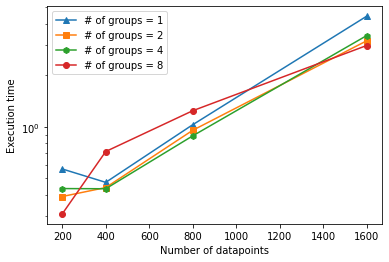

In [37]:
for i in range(4):
    result = []
    for j in range(4):
        result.append(durations[j][i])
    
    plt.plot(X, result, marker=marker[i], label="# of groups = {}".format(gr[i]))


plt.xlabel("Number of datapoints")
plt.ylabel("Execution time")
plt.yscale('log')

plt.legend(loc='upper left', fontsize=10)

plt.show()

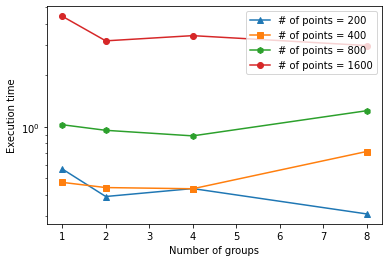

In [38]:
for i in range(4):
    result = []
    for j in range(4):
        result.append(durations[i][j])
    
    plt.plot(gr, result, marker=marker[i], label="# of points = {}".format(X[i]))


plt.xlabel("Number of groups")
plt.ylabel("Execution time")
plt.yscale('log')

plt.legend(loc='upper right', fontsize=10)

plt.show()